In [1]:
import os, signal, sys

import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import conv1d
import torchvision

from time import time

sys.path.insert(0, '../')
import musicnet
from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import matplotlib.pyplot as plt

from pypianoroll import Multitrack, Track, load, parse

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

In [3]:
def get_audio_segment(filepath,s, window):
    sz_float = 4 # size of a float
    epsilon = 10e-8 # fudge factor for normalization
    """
    Args:
        filepath (str): path to the bin file
        s (int): Start position of segment
        window (int): how many data points to get
    Returns:
        audio waveform
    """

    with open(filepath, 'rb') as f:
        f.seek(s*sz_float, os.SEEK_SET)
        x = np.fromfile(f, dtype=np.float32, count=int(scale*window))

    x /= np.linalg.norm(x) + epsilon

    return x

In [4]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()      
        # Create filter windows
        wsin, wcos = musicnet.create_filters(n_fft,k, low=50, high=6000,
                                      windowing="hann", freq_scale='log')
        self.wsin = torch.Tensor(wsin)
        self.wcos = torch.Tensor(wcos)               
        # Creating Layers
        
        k_out = 128
        k2_out = 256
        self.CNN_freq = nn.Conv2d(1,k_out,
                                kernel_size=(128,1),stride=(2,1))
        self.CNN_time = nn.Conv2d(k_out,k2_out,
                                kernel_size=(1,25),stride=(1,1))        
        self.linear = torch.nn.Linear(k2_out*193, m, bias=False)

        # Initialize weights
            # Do something
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2) # shape = (batch, 512,25)
        zx = torch.log(zx + 1e-12)
        z2 = torch.relu(self.CNN_freq(zx.unsqueeze(1))) # Make channel as 1 (N,C,H,W) shape = [10, 128, 193, 25]
        z3 = torch.relu(self.CNN_time(z2)) # shape = [10, 256, 193, 1]
        y = self.linear(torch.relu(torch.flatten(z3,1)))
        return y
    
class spectrograms_stft(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(spectrograms_stft, self).__init__()
        # Create filter windows for stft
        wsin, wcos = musicnet.create_filters(n_fft,k, windowing="no", freq_scale='linear')
        self.wsin = torch.tensor(wsin, dtype=torch.float)
        self.wcos = torch.tensor(wcos, dtype=torch.float)
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m, bias=False)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2) # Doing STFT by using conv1d
        return self.linear(torch.log(zx + 10e-8).view(x.data.size()[0],regions*k))
    

In [5]:
model = spectrograms_stft()
model = model.to(device)

In [6]:
model.load_state_dict(torch.load('../weights/spectrograms_stft'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [7]:
def access_full(path):
    with open(path, 'rb') as f:
        x = np.fromfile(f, dtype=np.float32)
    return x

In [13]:
def get_piano_roll(filepath, model, device, window=16384, stride=1000, offset=44100, count=7500, batch_size=500, m=128):
    sf=4
    x = access_full(filepath)
    if stride == -1:
        stride = (x.shape[0] - offset - int(sf*window))/(count-1)
        stride = int(stride)
        print("Number of stride = ", stride)
    else:
        count = (x.shape[0]- offset - int(sf*window))/stride + 1
        count = int(count)
        
    X = np.zeros([count, window])
    Y = np.zeros([count, m])    
        
    for i in range(count):
        X[i,:] =  x[offset+i*stride:offset+i*stride+window]
        #et_audio_segment(rec_id, offset+i*stride)
    
    with torch.no_grad():
        Y_pred = torch.zeros([count,m])
        for i in range(len(X)//batch_size):
            print(f"{i}/{(len(X)//batch_size)} batches", end = '\r')
            X_batch = torch.tensor(X[batch_size*i:batch_size*(i+1)]).float().to(device)
            Y_pred[batch_size*i:batch_size*(i+1)] = model(X_batch).cpu()
    
    return Y_pred, x

In [9]:
def export_midi(Y_pred, path):
    # Create a piano-roll matrix, where the first and second axes represent time
    # and pitch, respectively, and assign a C major chord to the piano-roll
    # Create a `pypianoroll.Track` instance
    track = Track(pianoroll=Y_pred*127, program=0, is_drum=False,
                  name='my awesome piano')   
    multitrack = Multitrack(tracks=[track], tempo=60, beat_resolution=86)
    multitrack.write(path)    

In [10]:
folder = '../data/test_data/'
files = ['1759.bin', '2106.bin', '2382.bin', '2556.bin']
filepath_list = [os.path.join(folder, i) for i in files]

In [11]:
for filepath in filepath_list:
    Y_pred = get_piano_roll(filepath, model, device,
                                window=window, m=m, stride=512)
    Yhatpred = Y_pred.cpu().numpy() > 0.4
    export_midi(Yhatpred, './spectrograms_stft_{}_{}_Y_pred.mid'.format('transcription_',os.path.basename(filepath)[:-4]))

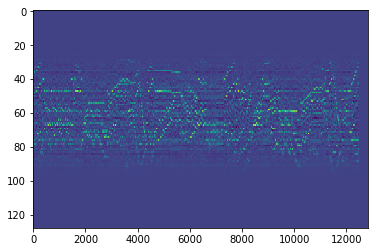

In [12]:
plt.imshow(np.transpose(Y_pred.cpu()), aspect='auto')

In [15]:
Y_pred, x = get_piano_roll(filepath, model, device, window=window, m=m, stride=512)

In [17]:
np.save('./x.npy',x)